# Features

In [1]:
import pandas as pd
from os import listdir
from os.path import isfile, join

import json
import re
from bs4 import BeautifulSoup
import email
import urllib
import base64
import string
import quopri
import time

import numpy as np

import seaborn as sns
import sklearn.utils

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import words

from sklearn.feature_extraction.text import TfidfVectorizer
import joblib

import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline    
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, plot_confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn import metrics

In [2]:
# import dataframe
df = joblib.load("exports/dataframe.sav")

In [3]:
len(df)

62701

In [5]:
df_spam = df[df["spam"] == 1]

In [6]:
df_ham = df[df["spam"] == 0]

In [7]:
len(df_spam)

34291

In [8]:
len(df_ham)

28410

# Outliers

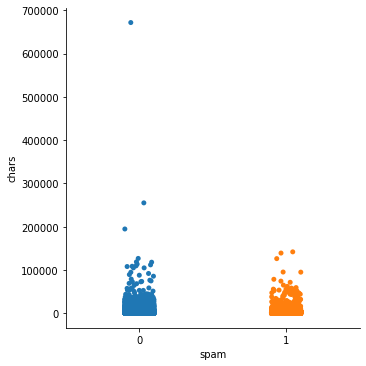

In [4]:
sns.catplot(x="spam", y="chars", data=df)

In [5]:
len(df[df['chars'].map(lambda d: d) > 190000])

3

In [6]:
df[df['chars'].map(lambda d: d) > 190000]["raw_data"]

53324    change your settings: http://blo.gs/settings.p...
63715    On Fri Apr 27 14:43:55 2007, jkeen@verizon.net...
75545    commit a snapshot of the generated prototype h...
Name: raw_data, dtype: object

In [26]:
df[df['chars'].map(lambda d: d) > 190000]["raw_data"][63715][:1000]

'On Fri Apr 27 14:43:55 2007, jkeen@verizon.net wrote:\n> A file with coverage analysis will be supplied in a  \n> separate posting to this thread.\n\nAttached is a plain text version of the coverage analysis.  Coverage was run on a \'post-\nConfigure.pl\' basis:\n\n  $ cover -delete coverage/configure/\n  $ ./myconfigure.sh \n  $ PERL5OPT=-MDevel::Cover=-db,coverage/configure/ prove t/configure/*.t t/\npostconfigure/01-data_slurp.t "$@"\n  $ cover coverage/configure/ -report=text  -ignore_re \'(^(config\\/|lib\\/(?!P\narrot))|\\busr\\b)\' > ~/learn/parrot/coverage/postconfigure.coverage.txt\n\nkid51\nb\'Reading database from /Users/jimk/work/fresh/coverage/configure\\n\\n\\n---------------------------- ------ ------ ------ ------ ------ ------ ------\\nFile                           stmt   bran   cond    sub    pod   time  total\\n---------------------------- ------ ------ ------ ------ ------ ------ ------\\n/usr/local/bin/prove           73.7   43.8    0.0   46.7    n/a    1.1   61.

In [7]:
# outliers are legit mails --> do not remove (e.g. someone just sent code (diff) via mail ...)

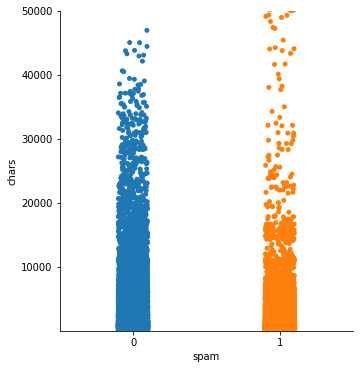

In [13]:
sns.catplot(x="spam", y="chars", data=df).set(ylim=(10, 50000))

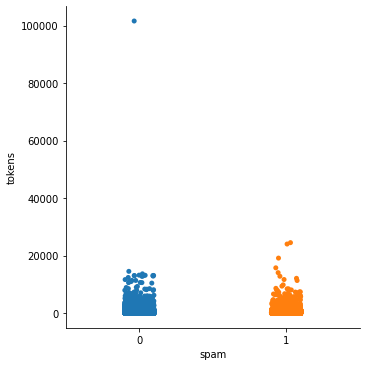

In [14]:
sns.catplot(x="spam", y="tokens", data=df)

In [17]:
df[df['tokens'].map(lambda d: d) > 90000]["raw_data"]

75545    commit a snapshot of the generated prototype h...
Name: raw_data, dtype: object

In [18]:
df[df['tokens'].map(lambda d: d) > 90000]["raw_data"][75545][:1000]

'commit a snapshot of the generated prototype headers\n---\nsource/client/client_proto.h     |  366 ++\nsource/include/proto.h           |10128 ++++++++++++++++++++++++++++++ \n++++++++\nsource/nsswitch/winbindd_proto.h |  516 ++\nsource/utils/net_proto.h         |  382 ++\nsource/utils/ntlm_auth_proto.h   |   28 +\nsource/utils/passwd_proto.h      |   12 +\nsource/web/swat_proto.h          |   49 +\n7 files changed, 11481 insertions(+), 0 deletions(-)\ncreate mode 100644 source/client/client_proto.h\ncreate mode 100644 source/include/proto.h\ncreate mode 100644 source/nsswitch/winbindd_proto.h\ncreate mode 100644 source/utils/net_proto.h\ncreate mode 100644 source/utils/ntlm_auth_proto.h\ncreate mode 100644 source/utils/passwd_proto.h\ncreate mode 100644 source/web/swat_proto.h\n\ndiff --git a/source/client/client_proto.h b/source/client/client_proto.h\nnew file mode 100644\nindex 0000000..f5027e8\n--- /dev/null\n+++ b/source/client/client_proto.h\n@@ -0,0 +1,366 @@\n+#ifndef _CLIENT_

In [20]:
# token outlier is chars outlier --> do not remove (same reason)

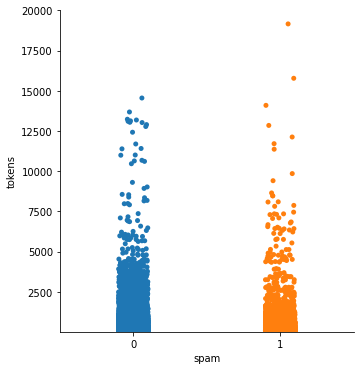

In [19]:
sns.catplot(x="spam", y="tokens", data=df).set(ylim=(10, 20000))

# Feature ideas

In [16]:
df.groupby(['spam', 'bad_domain']).size()

spam  bad_domain
0     0             27737
      1               673
1     0             34202
      1                89
dtype: int64

In [19]:
# bad_domain does not seem to be a good indicator
# there are more ham mails that contain blacklisted domains than spam mails ...

In [17]:
df.groupby(['spam', 'contains_urls']).size()

spam  contains_urls
0     0                 4087
      1                24323
1     0                 8402
      1                25889
dtype: int64

In [18]:
# url does not seem to be a good indicator due to the balanced distribution

# Feature importances

In [4]:
from matplotlib import pyplot
import math

In [7]:
# import vocabulary
vocab = joblib.load("exports/vocab.sav")
# import model
model = joblib.load("exports/model.sav")

In [37]:
importance = model.feature_importances_
important_features = []
most_important_feature = 0
most_important_feature_score = 0

# summarize feature importance
for i,v in enumerate(importance):
    if v > 0.005:
        print('Feature: %0d, Score: %.5f' % (i,v))
        important_features.append(i)
        if v > most_important_feature_score:
            most_important_feature_score = v
            most_important_feature = i
        
x = [x for x in range(len(importance))]
y = importance
low = min(y)
high = max(y)

Feature: 9580, Score: 0.00761
Feature: 9927, Score: 0.00622
Feature: 10659, Score: 0.00542
Feature: 12432, Score: 0.00690
Feature: 18301, Score: 0.00679
Feature: 21466, Score: 0.00605
Feature: 28685, Score: 0.01183
Feature: 28883, Score: 0.00554
Feature: 29700, Score: 0.01102
Feature: 29707, Score: 0.01902
Feature: 31527, Score: 0.00824
Feature: 33864, Score: 0.00785
Feature: 36794, Score: 0.00566
Feature: 37743, Score: 0.00727
Feature: 38157, Score: 0.00581
Feature: 38699, Score: 0.00635
Feature: 39212, Score: 0.00623
Feature: 40365, Score: 0.00501
Feature: 41407, Score: 0.00730
Feature: 52312, Score: 0.00990
Feature: 54730, Score: 0.01390
Feature: 55305, Score: 0.00521
Feature: 55306, Score: 0.00907


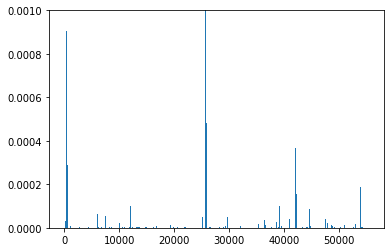

In [38]:
# plot feature importance
pyplot.ylim([low, 0.001])

pyplot.bar(x, y)
pyplot.show()

In [39]:
high

0.01901974325590954

In [40]:
low

0.0

In [41]:
important_features

[9580,
 9927,
 10659,
 12432,
 18301,
 21466,
 28685,
 28883,
 29700,
 29707,
 31527,
 33864,
 36794,
 37743,
 38157,
 38699,
 39212,
 40365,
 41407,
 52312,
 54730,
 55305,
 55306]

In [45]:
list(vocab)[most_important_feature]

'felix'

In [46]:
most_important_feature_score

0.01901974325590954

In [47]:
firstIndexError = True
for f in important_features:
    try:
        print(list(vocab)[f])
    except IndexError:
        if firstIndexError:
            print(f, "(#tokens)")
            firstIndexError = False
        else:
            print(f, "(#chars)")

summit
sidecar
cranford
asem
nerds
pullen
uec
ipo
polity
felix
patroclus
shelley
unconquered
incipient
caliber
momentarily
rashid
topics
tyrant
omm
apiology
55305 (#tokens)
55306 (#chars)


In [48]:
# char size and tokens size seem to be good indicator according to feature_importances_